# Introduction to Bayesian Inference for climate scientists

## Part 3. Linear regression

In the first session we covered Bayesian probability, Bayes Theorem and explicit calculation of the posterior.

We are now going to examine a linear regression.  We will keep it simple by building models with a single predictive parameter.

In this session we will cover:

1) Bayesian linear regression

2) cross validation

3) model comparison

We start with some package imports.


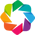

In [3]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn import preprocessing
import pymc3 as pm
import theano.tensor as ttens


import holoviews as hv
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.layouts import column

hv.notebook_extension('bokeh')
%matplotlib inline

## Deterministic linear regression

The aim of \emph{deterministic} linear regression is to estimate the 
intercept and slopes when regressing an predictor matrix $X$
on an outcome variable $y$:
\begin{equation}
 \mathbf{y} = \mathbf{\alpha} + X \cdot \mathbf{\beta} + \epsilon
\end{equation}
where:

* $\alpha$ is the intercept 

* $\mathbf{\beta}$ is a vector of regression slopes

* $\epsilon$ is the scalar error variable.

* $X$ is the *predictor* array

$X$ has shape ($N$,$K$) where $N$ is the number of data points and $K$ is the number of *features*.

In deterministic linear regression the aim is to make point estimates of the 
parameters $\alpha$, $\mathbf{\beta}$ to find the line of best fit.

## Bayesian linear regression
In Bayesian linear regression, on the other hand, the aim is to infer the probability distribution function (PDF) for the parameters $\alpha$, $\beta$ and $\sigma$ rather than point estimates.  

To illustrate how Bayesian linear regression works, we first have an example with fake data.

In [45]:
# Number of data points
N = 100
# Intercept
alpha = 1
# Slope
beta = 2
# Predictor
X = np.linspace(-6,6, N)
# Target
y = alpha + (beta * X) + np.random.normal(0,3,size=N)
# Turn X from a vector into a 1D array
X = X[:,np.newaxis]

fake_scatter = hv.Points((X[:,0],y), group="Scatter plot of fake data")
fake_scatter

:Points   [x,y]

We see that the data is scattered around the line $y = 1 + 2X$.

### Likelihood
The Bayesian linear regression model is specified with the likelihood of 
the model:
$$  \mathbf{y} \sim \mathcal{N}(\mathbf{\mu}, \sigma)$$
$$  \mathbf{\mu} = \alpha +  \mathbf{X} \cdot \mathbf{\beta}$$


The parameter vector $\mathbf{\theta} = (\alpha, \beta_{0},..., \beta_{K},\sigma)$ where
$\alpha$ is the intercept, $\beta_{i}$ is a regression slope for feature $i$ and $\sigma$ is the standard deviation.
### Priors
We need prior distributions for each of the parameters. We take the priors to be:
$$\alpha \sim \mathcal{N}(0, 1),$$
$$  \beta_{i} \sim \mathcal{N}(0, 1)$$ and
$$  \sigma \sim \mathcal{N}^{+}(0, 1)$$

where $\mathcal{N}^{+}$ means that only positive values in the distribution are taken.  We discuss the basis for choosing the priors more in the example with real data below.



## Specifying a linear regression model in PyMC3

This linear regression model is specified in a similar way to the univariate normal distribution in Part 2.  The main difference is that we must specify that $\mu$ is a function of $\alpha$ and $\beta$.

In [46]:
def linear_regression(X, y, 
                      alpha_prior, beta_prior, sigma_prior,
                      samples = 1000, njobs = 2):
    # Number of predictors
    K = X.shape[1]
    # Number of data points
    N = X.shape[0]

    with pm.Model() as model: 
        #Specify priors
        alpha = pm.Normal('alpha', mu = alpha_prior['mu'], sd = alpha_prior['sd'])
        beta = pm.Normal('beta', mu = beta_prior['mu'], sd = beta_prior['sd'], shape = int(K))
        sigma = pm.HalfNormal('sigma', sd = sigma_prior['sd'])
        
        # Specify regression relationship in mu
        # Need to use the Theano dot product function to combine beta and X
        mu = alpha + ttens.dot(beta,X.T)
        
        # Specify likelihood
        Y_obs = pm.Normal('Y_obs', mu = mu, sd = sigma, observed = y)
        
        # Fit the model
        trace = pm.sample(draws = samples, njobs = njobs)
        
        # Generate data from the model
        simulate_data = pm.sample_ppc(trace=trace,model=model)
    return model, trace, simulate_data

The model code is similar to fitting a univariate normal distribution.  The difference is that $\mu$ is now the regression relationship $\mu = \alpha + X \cdot \beta$.  As PyMC3 uses Theano as its computational backend, we must be the Theano dot product function ```ttens.dot``` to do the matrix multiplication of $\beta$ and $X$.

Now we specify the priors and fit the model for this *fake data* example.

In [47]:
alpha_prior = {'mu':0, 'sd':1}
beta_prior = {'mu':0, 'sd':2}
sigma_prior = {'sd':2}

model_fake, trace_fake, simulated_data_fake = linear_regression(X,y,
                                                alpha_prior = alpha_prior,
                                                beta_prior = beta_prior,
                                                sigma_prior = sigma_prior,
                                                njobs = 4)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = -258.27: 100%|██████████| 200000/200000 [00:11<00:00, 16774.92it/s]
Finished [100%]: Average ELBO = -258.3
INFO:pymc3:Finished [100%]: Average ELBO = -258.3
100%|██████████| 1000/1000 [00:58<00:00, 17.36it/s]


We examine the diagnostics of the model fit to ensure the algorithm performed satisfactorily.

In [48]:
pm.diagnostics.gelman_rubin(trace_fake)

{'alpha': 1.0008694891774115,
 'beta': array([ 0.99994605]),
 'sigma': 1.0000866727628674,
 'sigma_log_': 1.0000958368283366}

These values are close to 1 and so should be acceptable.  Now we check the number of effective samples.

In [49]:
pm.diagnostics.effective_n(trace_fake)

{'alpha': 2570.0,
 'beta': array([ 2880.]),
 'sigma': 2540.0,
 'sigma_log_': 2528.0}

These are all greater than 1000 and so should be sufficient for our purposes.  Now we can look at the posterior distributions of the parameters.

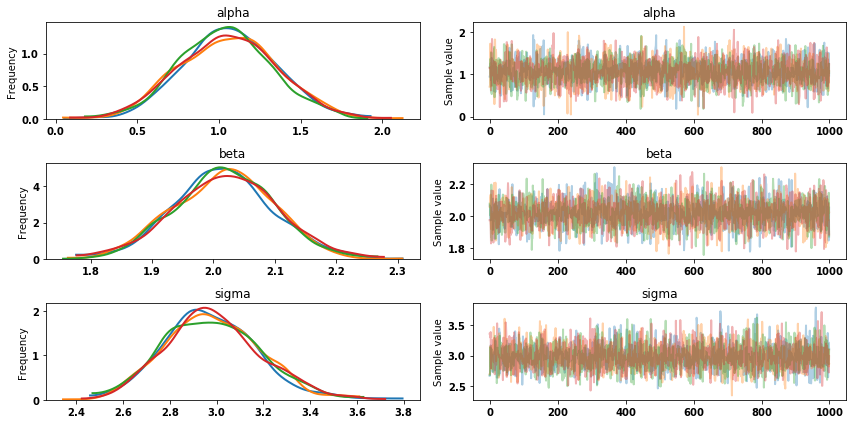

In [50]:
pm.traceplot(trace_fake);

The true intercept is $\alpha = 1$ and the model has found values that are a bit lower than this.

The true slope is $\beta = 2$ and the model has found values that are biased slightly lower than this.

The standard deviation is $\sigma = 3$ and the model has found values close to this.

The difference between the true values and the centre of the model PDFs is mainly due to the significant noise in the data.  

Using the values of $\alpha$ and $\beta$, we can fit regression lines to the data.

### Get the line of best fit
We can recover the line of best fit by using the posterior distributions of $\alpha$ and $\beta$ while ignoring $\sigma$.  We show an example of how we use $\sigma$ below.

In [67]:
# Get the lines through the data set with no noise
mu = trace_fake.get_values('alpha')[:,np.newaxis] + trace_fake.get_values('beta')*X.T

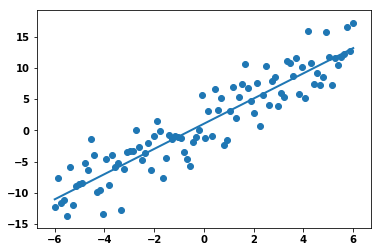

In [68]:
# Plot the line of best fit as the mean of mu
plt.plot(X[:,0],mu.mean(axis=0));
# Plot the original fake data
plt.scatter(X[:,0],y)

## Regression with temperature and CO2 data

### Datasets

We are going to look at two datasets.  The first is the daily mean Stockholm weather data we have already used.

In [69]:
# Create a dataframe df that holds the daily weather data
df = pd.read_csv('data/temp_rain_1960_to_2017.csv',index_col='date', parse_dates=True)
# Select the period that overlaps with the temperature data
trim = df.loc['1962-01-01':'2016-12-31']
# Create a new dataframe with the annual mean weather data
annual = trim.groupby(trim.index.year).mean()
# Print the first five rows of the dataset
annual.head()

precip      temp
date                    
1962  1.660000  5.733699
1963  1.423288  6.050685
1964  1.027322  6.770765
1965  1.591781  5.783836
1966  1.513151  5.838904

The second dataset is the record of CO2 from Mauna Loa in Hawaii.  Again, we'll take the annual mean data and trim the dataset to cover the same period as the temperature data.

In [ ]:
# Create a dataframe called maunca that holds the daily CO2 data
# The parse_dates=True means that it interprets the date column in the .csv file as a date
mauna = pd.read_csv('data/mauna_loa.csv',index_col='date',parse_dates=True)
# Create a new dataframe with the annual mean data
annual_mauna = mauna.groupby(mauna.index.year).mean()
# Select the period that overlaps with the temperature data
annual_mauna = annual_mauna.loc['1961-12-31':'2016-12-31']
# Print the first five rows of the annual mean data
annual_mauna.head()

## Visual inspection
As ever, we begin by inspecting the data.  We plot both the time series for the overlapping period from 1962 to 2016.

In [70]:
%%output size=150
%%opts Curve.CO2 (color="red")
co2_ann = hv.Curve((annual_mauna.index,annual_mauna.co2), 
                      kdims=["Year"],vdims=["Annual mean CO2 concentration (ppm)"],
                      group="CO2")
temp_ann = hv.Curve((annual.index,annual.temp), 
                    kdims=["Year"],vdims=["Temperature degrees C"],
                   group="Temperature")

co2_ann + temp_ann

:Layout
   .CO2.I         :Curve   [Year]   (Annual mean CO2 concentration (ppm))
   .Temperature.I :Curve   [Year]   (Temperature degrees C)

We see that there is an almost continual increase in the annual mean CO2 concentration over this period.  The annual mean temperature in Stockholm is much more variable, but it too has an increasing trend over this period.


In [71]:
print("Estimated temperature change is {:.2f} degrees per unit CO2 ".format( (annual.temp.iloc[-1]-annual.temp.iloc[0])/(annual_mauna.co2.iloc[-1]-annual_mauna.co2.iloc[0])))

Estimated temperature change is 0.03 degrees per unit CO2 


To examine the  relationship a bit more closely, we can compare the CO2 concentration and the temperature in a scatter plot.

In [72]:
%%output size=150 # Set figure size
%%opts Scatter (size=7)

co2_temp = hv.Scatter((annual_mauna.co2.values, annual.temp.values),
                               kdims=["CO2 ppm"], vdims = ["Temperature degrees C"],
                                                  group = 'Original units')

# Output the scatter plot
co2_temp

:Scatter   [CO2 ppm]   (Temperature degrees C)

We have confirmation that higher values of CO2 are generally associated with higher values of temperature, though with considerable variability.

While the dots lining up on a scatter plot could simply be a [spurious correlation](http://www.tylervigen.com/spurious-correlations) numerous studies suggest that higher concentrations of CO2 in the atmopshere lead to higher surface temperatures.  Furthermore, these studies suggest that the global mixing time for CO2 is short, and so the values observed on Mauna Loa are relevant even for places half the world away in Scandinavia.

On this basis we're going to model the temperature in Stockholm as a function of the CO2 concentration on Mauna Loa.


### Centering and standardizing the data

Machine learning algorithms are often senstive to the scales in the data. The scales for CO2 are that the mean CO2 values are in the 100s and the variability is in the 10s.  The scales for temperature are means values of close to 5 and variability close to 1.  Using algorithms with these scales often leads to poor inferences.

This can be addressed by centering and standardizing the data.  In this case we will center and standardize both the CO2 and the temperature data.  The process of centering in statistics is similar to the process of looking at anomalies with respect to some background mean state in physics.  The process of standardizing in statistics is similar to the process of non-dimensionalising data in physics.

To carry out the centering and standardizing, we use the ```preprocessing``` module from the sklearn machine learning library.

In [96]:
# Get the parameters for the centering and standardization
scaler_temp = preprocessing.StandardScaler().fit(annual.temp.values[:,np.newaxis])
# Apply these parameters to a new scaled temperature series
annual['temp_scaled'] = scaler_temp.transform(annual.temp[:,np.newaxis])

scaler_co2 = preprocessing.StandardScaler().fit(annual_mauna.co2.values[:,np.newaxis])
# Apply these parameters to a new scaled temperature series
annual_mauna['co2_scaled'] = scaler_co2.transform(annual_mauna.co2[:,np.newaxis])

The following plots compare the scaled and unscaled data to show that they are geometrically the same.

In [74]:
%%opts Scatter (size=7)

co2_temp_scaled = hv.Scatter((annual_mauna.co2_scaled.values, annual.temp_scaled.values),
                               kdims=["CO2 ppm"], vdims = ["Temperature degrees C"],
                             group = 'scaled') 
co2_temp_scaled

:Scatter   [CO2 ppm]   (Temperature degrees C)

In [75]:
co2_temp

:Scatter   [CO2 ppm]   (Temperature degrees C)

## Specify the model mathematically

As above, we use a normal distribtion of the likelihood.
$$  \mathbf{y} \sim \mathcal{N}(\mathbf{\mu}, \sigma)$$
$$  \mathbf{\mu} = \alpha +  \mathbf{X} \cdot \mathbf{\beta}$$


As above, the parameter vector $\mathbf{\theta} = (\alpha, \beta_{0},..., \beta_{K},\sigma)$ where
$\alpha$ is the intercept, $\beta_{i}$ is a regression slope for feature $i$ and $\sigma$ is the standard deviation.
### Priors
We need prior distributions for each of the parameters. We take the priors to be:
$$\alpha \sim \mathcal{N}(0, 3),$$
$$  \beta_{i} \sim \mathcal{N}(0, 3)$$ and
$$  \sigma \sim \mathcal{N}^{+}(0, 3)$$

where $\mathcal{N}^{+}$ means that only positive values in the distribution are taken.  The process of centering and standardization means that we can use these generic priors for many problems. The exact numberical values used - especially for the standard deviations in $\alpha$, $\beta$ and $\sigma$ should be varied to see how it affects the inference.  These kinds of prior are known as **weakly-informative priors**.


We can justify the use of weakly-informative priors because the data are centered and
normalised.  As such we expect the intercept to be close to 0 and the values of the regression slopes in $\mathbf{\beta}$
and the standard deviation $\sigma$ to be order 1.  As such the priors we have chosen act
to prevent these parameters from taking extreme values due to noise in the data.  We expect that by 
preventing the parameters from taking such extreme values the model performance out-of-sample is improved.

[Michael Betancourt has written more about the effect of weakly-informative priors on a regression analysis](http://mc-stan.org/users/documentation/case-studies/weakly_informative_shapes.html).


### Creating the dataset
We now create the data vector and array that we feed to PyMC3.  In this case we are fitting a linear trend to the data, so $y$ is the annual mean temperature and $X$ is the predictor CO2 data. 

We have 55 years of data.  However, it is a good idea to split your data into a **training dataset** and a **testing dataset**.  We use the training dataset to fit the model.  We then explore how well the model performs in comparison to the testing dataset that it hasn't seen before.

In this case we take the data from 1962-1992 as the training data and the data from 1993-2016 as the testing data.

We assume that the 55 years of data is **independently and identically distributed**.

In [161]:
# Specify our target vector y and our standardized feature array X
y_train_scaled = annual.temp_scaled.loc[1962:1992].values
y_train = annual.temp.loc[1962:1992].values
y_test = annual.temp_scaled.loc[1993:].values

# X needs to be an array rather than a vector, so we do [:,np.newaxis] to transform it from a vector to a 1D array
X_train_scaled = annual_mauna.co2_scaled.loc[1962:1992].values[:,np.newaxis]
X_train = annual_mauna.co2.loc[1962:1992].values[:,np.newaxis]

X_test = annual_mauna.co2_scaled.loc[1993:].values[:,np.newaxis]

time_train = annual.index[:31]
time_test = annual.index[32:]

### Fit the model
We can now fit the model to the **training dataset**.

In [ ]:
alpha_prior = {'mu':0, 'sd':3}
beta_prior = {'mu':0, 'sd':3}
sigma_prior = {'sd':3}

model, trace, simulated_data = linear_regression(X_train_scaled,y_train_scaled,
                                                alpha_prior = alpha_prior,
                                                beta_prior = beta_prior,
                                                sigma_prior = sigma_prior)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = -49.225: 100%|██████████| 200000/200000 [00:11<00:00, 17072.64it/s]
Finished [100%]: Average ELBO = -49.222
INFO:pymc3:Finished [100%]: Average ELBO = -49.222
  5%|▍         | 46/1000 [00:02<00:53, 17.90it/s]

As before, we inspect the model fit for problems.

In [92]:
pm.diagnostics.gelman_rubin(trace)

{'alpha': 1.0038708577290725,
 'beta': array([ 1.00372578]),
 'sigma': 0.99987928890883127,
 'sigma_log_': 1.0001017725932893}

All the values are close to 1 here, so the fit should be ok.

In [93]:
pm.diagnostics.effective_n(trace)

{'alpha': 344.0, 'beta': array([ 371.]), 'sigma': 953.0, 'sigma_log_': 993.0}

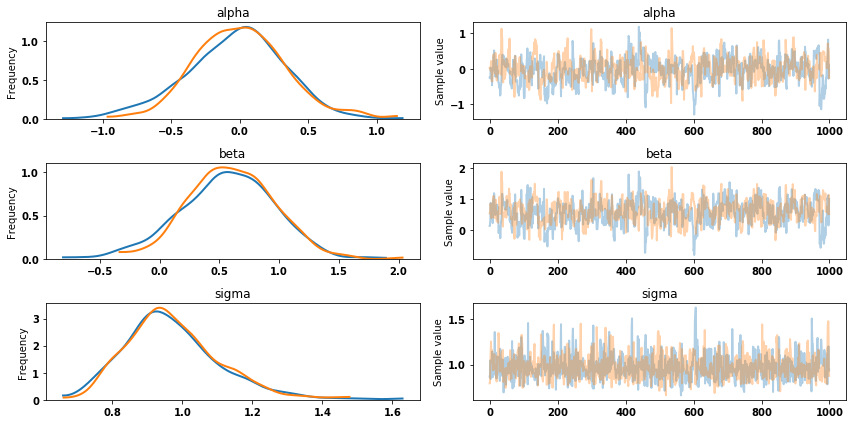

In [117]:
pm.traceplot(trace);

We see that the chains have not coverged to exactly the same posteriors, but it's not a diasaster either. It would probably be worth increasing the number of samples in the posterior to see if that helps things.

### Reverting the the original scales
We would prefer to have our samples for $\alpha$, $\beta$ and $\sigma$ back in their original scales.

For the intercept $\alpha$ we do this with:

In [128]:
alpha = (trace.get_values('alpha')*scaler_temp.scale_) + annual.temp.mean() -(trace.get_values('beta')[:,0]*(scaler_temp.scale_/scaler_co2.scale_)*annual_mauna.co2.mean())

While for the slope $\beta$ we recover the original units with:

In [112]:
beta = trace.get_values('beta')*(scaler_temp.scale_/scaler_co2.scale_)

print('Mean value of the regression slope is {:.2}'.format(beta.mean()))

Mean value of the regression slope is 0.023


In [115]:
sigma = trace.get_values('sigma')
sigma.mean()

0.97273818362582776

In [118]:
%%output size=150
mod = hv.Curve((annual.index, alpha.mean() + beta.mean()*annual_mauna.co2.values))
data = hv.Curve((annual.index,annual.temp),kdims=["Year"],vdims=["Temperature"])
data*mod

:Overlay
   .Curve.I  :Curve   [Year]   (Temperature)
   .Curve.II :Curve   [x]   (y)

Now we want to compare the *probabilistic* model prediction with the training data.  To do so we take our samples of
$\alpha$,$\beta$ and $\sigma$ and combine them with our CO2 predictor $X$ to generate data from our model
$$ y \sim \mathcal{N}(\mu,\sigma)$$
or
$$ y \sim \mathcal{N}(\alpha + X\cdot \beta,\sigma)$$

In [160]:
y_train[0]

-1.4469727233476333

In [134]:
# Generate the predictions for \mu under the model with shape (4000,55)
mu = alpha[:,np.newaxis] + beta*X_train
# Generate samples from the model
model = np.random.normal(mu,sigma[:,np.newaxis])
# Calculate some statistics from the model predictions
model_mean = model.mean(axis=0)
model_upper = np.percentile(model,97.5,axis=0)
model_lower = np.percentile(model,2.5,axis=0)

We can compare the model predictions with the data *over the training period*. 

In [135]:
def uncertain_prediction(time_index,data, model_mean, model_lower,model_upper, 
                         title = 'Data versus model prediction', ylabel = 'Temperature', xlabel = 'Year'):
    """Make a bokeh plot to show the probability distribution function for rho compared with its true value
    
    Inputs:
    time_index: (1d array) - Time index for x-axis
    data: (1d array) - Observed data
    model_mean (1d array) - Mean of model predictions
    model_lower: (1d array) - Lower bound for temperature in 95% range
    model_upper: (1d array) - Upper bound for temperature in 95% range
    """
    #Have to append a reversed series for the patch coordinates
    band_x = np.append(time_index, time_index[::-1])
    band_y = np.append(model_lower, model_upper[::-1])
    p = figure(title= title, height = 500, width = 900)
    p.line(time_index, data, color = 'blue')
    p.line(time_index, model_mean, color = 'black')
    p.patch(band_x, band_y, color='green', fill_alpha=0.5, line_color = "green")
    p.xaxis.axis_label = xlabel
    p.yaxis.axis_label = ylabel
    show(p)

In [147]:
uncertain_prediction(time_train, y_train,model_mean,model_lower,model_upper, 
                     title="Data and model 95% range")

We see that the model is effective over the training period in capturing the trend and variability in the data.

## Training and testing
Statistical models often do well in fitting to the data for the period in which they are trained.  However, we are mainly interested in whether the models *generalise* to other periods.  Using the example above, if we know that the CO2 concentration is likely to keep rising in the decades to come, will the same relationship with temperature in Stockholm hold?

To get a sense of how well the model might generalise, we can divide our data into a *training* period and a *testing* period.  We will fit the model in the training period and then examine whether it works well at predicting the new data that it has not seen in the test period.  In this case we will take the first 35 years to be the training period and the last 20 years as the test period.

We will also make some modifications to the Stan code that we used above.  Firstly, we will provide both the training and testing data as inputs.  This means, for example, that $N$ is replaced by $N_{train}$ and $N_{test}$.  We will also get Stan to generate the model predictions from the normal distribution instead of doing it outselves.

In [21]:
# Split the data into training and testing data
time_train = annual.index[:30]
time_test = annual.index[30:]

y_train = annual.temp.iloc[:30].values
X_train = annual_mauna.co2_scaled.iloc[:30].values[:,np.newaxis]

y_test = annual.temp.iloc[30:].values
X_test = annual_mauna.co2_scaled.iloc[30:].values[:,np.newaxis]

Fit the model to the *training* data

In [22]:
model2, trace2, simulated_data2 = linear_regression(X_train,y_train)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = -49.582: 100%|██████████| 200000/200000 [00:11<00:00, 17241.04it/s]
Finished [100%]: Average ELBO = -49.588
INFO:pymc3:Finished [100%]: Average ELBO = -49.588
100%|██████████| 1000/1000 [00:57<00:00, 18.50it/s]


In [41]:
alpha2 = trace2.get_values('alpha')[:,np.newaxis]  - annual_mauna.co2.mean()*trace2.get_values('beta')/scaler_co2.scale_
beta2 = trace2.get_values('beta')/scaler_co2.scale_
sigma2 = trace2.get_values('sigma')[:,np.newaxis]

# Generate the predictions for \mu under the model with shape (4000,55)
mu_train = alpha2 + np.dot(beta2,X_train.T)
mu_test = alpha2 + np.dot(beta2,X_test.T)

# Generate samples from the model
yfit_train = np.random.normal(mu_train,sigma2)
yfit_test = np.random.normal(mu_test,sigma2)


In [48]:
alpha.mean()

-1.3203863895388248

In [31]:
predicted_values = {}
predicted_values['yfit_train'] = yfit_train
predicted_values['yfit_test'] = yfit_test
predicted_values['time_test'] = time_test
predicted_values['time_train'] = time_train

In the *data* block we have now separated the variables into training and testing variables.

We have also add a *generated quantities* block.  This block will produce the predicted values by drawing from a normal distribution as we did manually above.

The output is a bit more verbose this time, as it includes the *generated quantities* $yfit_train$ and $yfit_test$ as well as the regression parameters.  Overall we still have over a thousand effective samples for each of the three model parameters and so we should still be able to estimate the statistics of interest.

In [32]:
def uncertain_prediction_split(time_train,data_train, time_test, data_test,
                               predicted_values, 
                         title = 'Data versus model prediction', ylabel = 'Temperature', xlabel = 'Year'):
    """Make a bokeh plot to show the probability distribution function for rho compared with its true value
    
    Inputs:
    time_index: (1d array) - Time index for x-axis
    data: (1d array) - Observed data
    model_mean (1d array) - Mean of model predictions
    model_lower: (1d array) - Lower bound for temperature in 95% range
    model_upper: (1d array) - Upper bound for temperature in 95% range
    """
    p = figure(title= title, height = 500, width = 900)
    p.line(time_train, data_train, color = 'blue')
    p.line(time_test, data_test, color = 'blue')
    for key in ['yfit_train','yfit_test']:
        value = predicted_values[key]
        model_mean = value.mean(axis=0)
        model_lower = np.percentile(value,2.5,axis=0)
        model_upper = np.percentile(value,97.5,axis=0)
        #Have to append a reversed series for the patch coordinates
        band_y = np.append(model_lower, model_upper[::-1])
        if 'train' in key:
            band_x = np.append(predicted_values['time_train'], predicted_values['time_train'][::-1])

            p.line(time_train, model_mean, color = 'black')
            p.patch(band_x, band_y, color='green', fill_alpha=0.5, line_color = "green")
        else:
            band_x = np.append(predicted_values['time_test'], predicted_values['time_test'][::-1])
            p.line(time_test, model_mean, color = 'black')
            p.patch(band_x, band_y, color='firebrick', fill_alpha=0.5, line_color = "firebrick")
    p.xaxis.axis_label = xlabel
    p.yaxis.axis_label = ylabel
    show(p)

In [37]:
predicted_values['yfit_test'].min()

-18.478937420541328

In [34]:
uncertain_prediction_split(time_train, y_train, time_test, y_test, predicted_values)

The green area shows the model fit during the training period and the red area shows the model fit during the test period.  The model fits the data well during the green training period, but range of variability predicted by the model is quite large during the testing period in red.